# 3.1 COVID-19 – Our World In Data

## 3.1A

Use the owid-covid-data.csv file to reproduce the plot shown below, as accurately as possible. The upper panel contains both solid lines and dashed lines. The dashed lines are the smoothed version (column ‘new_cases_smoothed_per_million’). The remaining parts are self-explanatory. You will get marks for reproducing the plot as accurately as possible, taking into consideration the steps undertaken to reach the final figure.

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# filter data by iso_code, and cells with not 0 at requested column
def get_temp(df, iso_code, col):
    temp = df[(df["iso_code"] == iso_code) & (df[col] != 0)]
    return temp

In [3]:
# convert string list to "str1, str2, and str3"
def list_to_str(list):
    str = ""
    for i in range(len(list) - 1):
        str = str + list[i] + ", "
    return str + "and " + list[-1]

In [4]:
# convert string date to date
def get_date(date_in_str):
    return dt.datetime.strptime(date_in_str, "%Y-%m-%d")

In [5]:
# draw reference dates
def draw_ref_dates(start_date, ref_dates, ax):
    for date in ref_dates:
        d = (
            dt.datetime.strptime(date, "%Y-%m-%d")
            - dt.datetime.strptime(start_date, "%Y-%m-%d")
        ).days
        ax[0].axvline(x=d, color="grey")
        ax[1].axvline(x=d, color="grey")
        ax[0].text(
            d + 2,
            0.0011,
            date,
            verticalalignment="center",
            fontsize="medium",
            color="grey",
        )
        ax[1].text(
            d + 2,
            0.0019,
            date,
            verticalalignment="center",
            fontsize="medium",
            color="grey",
        )

In [6]:
# draw basic x,y axis elements
def draw_basic(countries, start_date, min_days, max_days, ax):
    ax[0].set_title(
        "New and Total COVID-19 Cases per Million in " + (list_to_str(countries))
    )
    ax[0].set_ylabel("New Cases per Million")
    ax[1].set_ylabel("Total Cases per Million")
    ax[1].set_xlabel("Days since " + start_date)
    for i in range(2):
        ax[i].set_xlim([min_days, max_days])
        ax[i].legend(loc="lower right")
        ax[i].set_yscale("log")

In [7]:
def plot_data(countries, colors, df, ax):
    for country, color in zip(countries, colors):
        temp = get_temp(df, country, "new_cases_per_million")
        ax[0].plot(
            temp["days"], temp["new_cases_per_million"], "-", label=country, color=color
        )
        temp = get_temp(df, country, "new_cases_smoothed_per_million")
        ax[0].plot(
            temp["days"], temp["new_cases_smoothed_per_million"], "--", color=color
        )
        temp = get_temp(df, country, "total_cases_per_million")
        ax[1].plot(
            temp["days"],
            temp["total_cases_per_million"],
            "-",
            label=country,
            color=color,
        )

In [8]:
def get_chart(data, colors, countries, min_days, start_date, ref_dates):

    # filter with iso_code in 'countries'
    # add a new column 'days' represting the days diff between 'date" column and 'start_date'
    # filter out 'days' smaller than min_days
    df = data[(data["iso_code"].isin(countries))].reset_index(drop=True)
    df["days"] = (pd.to_datetime(df["date"]) - get_date(start_date)).apply(
        lambda x: x.days
    )
    df = df[df["days"] >= min_days]
    fig, ax = plt.subplots(2, 1, figsize=[18, 8])
    plot_data(countries, colors, df, ax)
    draw_basic(countries, start_date, min_days, df.days.max(), ax)
    draw_ref_dates(start_date, ref_dates, ax)
    plt.show()

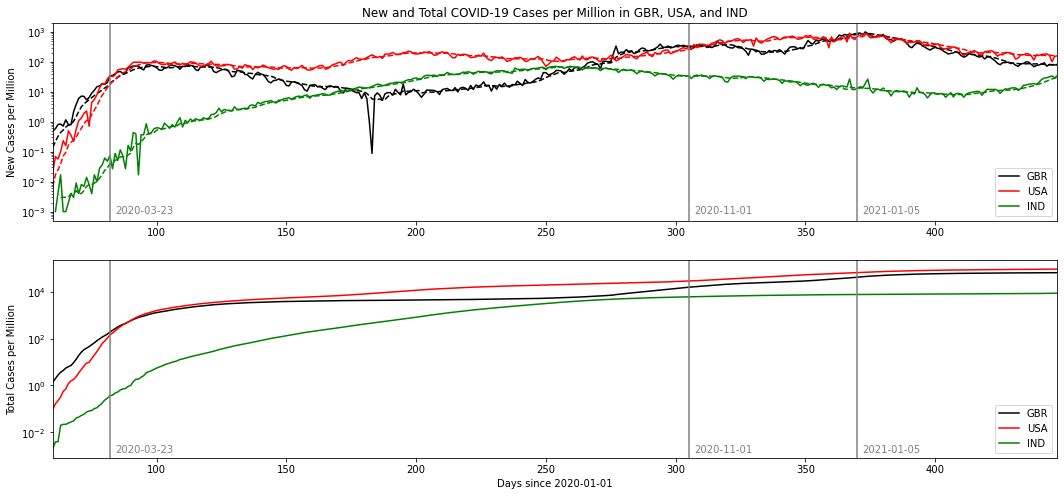

In [9]:
filepath = r"./owid-covid-data.csv"
data = pd.read_csv(filepath, low_memory=False)
get_chart(
    data,
    ["black", "red", "green"],
    ["GBR", "USA", "IND"],
    60,
    "2020-01-01",
    ["2020-03-23", "2020-11-01", "2021-01-05"],
)

## 3.1B

The figure below shows the trend of daily deaths count from January 1, 2020 to March 21, 2021 in various regions.
1. The first wave of death outbreaks in Europe and North America are from January to April 2020, reaching a peak around early April, and then beginning to drop. It remained in a relatively stable trend until October 2020, the curve began to turn upwards, reaching its peak at the end of January 2021. 
2. The death curve in North America, Africa, Asia and Oceania has maintained a relatively stable trend since the beginning of the pandemic. However, the recent daily death curve in North America has suddenly turned upwards, which may indicate that there might be a new wave coming.

In [10]:
def plot_data_td(ax, df, continents, colors, start_date):
    for i, val in enumerate(continents):
        df_c = df[(df["continent"] == val)].reset_index(drop=True)
        temp = df_c.groupby(["date"]).sum().reset_index()
        temp["days"] = (pd.to_datetime(temp["date"]) - get_date(start_date)).apply(
            lambda x: x.days
        )
        ax.plot(
            temp["days"], temp["new_deaths_smoothed"], "-", label=val, color=colors[i]
        )

In [11]:
def draw_side_text(ax, df, continents, colors):
    ax.text(-50, 5500, "Total COVID-19 Death Cases", fontsize=16)
    ax.text(-50, 5200, "(Up to " + str(df["date"].max()) + ")", fontsize=10)
    for i, val in enumerate(continents):
        df_c = df[(df["continent"] == val)].reset_index(drop=True)
        idx = df_c.groupby(["location"])["date"].transform(max) == df_c["date"]
        ax.text(
            -50,
            4500 - i * 350,
            val + ": " + str(int(df_c[idx]["total_deaths"].sum())),
            fontsize=14,
            color=colors[i],
        )

In [12]:
def draw_ref_dates_td(start_date, ref_dates, ax):
    for date in ref_dates:
        d = (
            dt.datetime.strptime(date, "%Y-%m-%d")
            - dt.datetime.strptime(start_date, "%Y-%m-%d")
        ).days
        ax.axvline(x=d, color="grey")
        ax.text(
            d + 2,
            100,
            date,
            verticalalignment="center",
            fontsize="medium",
            color="grey",
        )

In [13]:
def get_chart_td(data, colors, min_days, start_date, ref_dates):
    df = data[data["continent"].notnull()].reset_index(drop=True)
    df["days"] = (pd.to_datetime(df["date"]) - get_date(start_date)).apply(
        lambda x: x.days
    )
    max_x = df["days"].max()
    max_y = df.groupby(["continent", "date"])["new_deaths_smoothed"].sum().max()
    continents = df["continent"].unique()
    fig, ax = plt.subplots(1, 1, figsize=[18, 8])
    ax.set_title("COVID-19 New Deaths by Continent")
    ax.set_xlabel("Days since " + start_date)
    ax.set_ylabel("COVID-19 New Deaths Count")
    ax.set_xlim([60, max_x])
    ax.set_ylim([0, max_y])
    draw_side_text(ax, df, continents, colors)
    plot_data_td(ax, df, continents, colors, start_date)
    draw_ref_dates_td(start_date, ref_dates, ax)
    ax.legend(loc="upper center")
    plt.show()

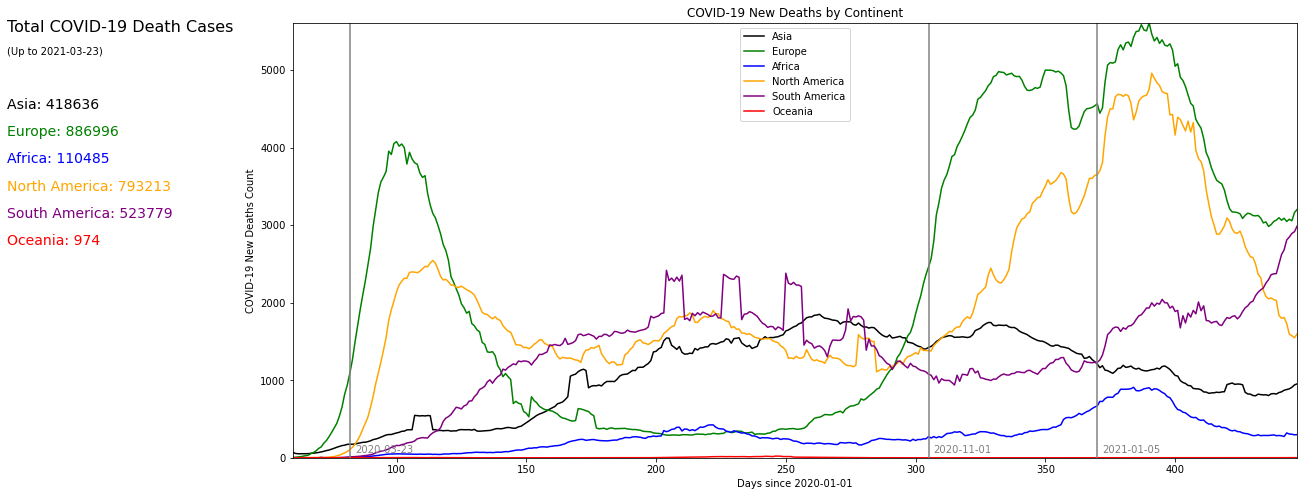

In [14]:
get_chart_td(
    data,
    ["black", "green", "blue", "orange", "purple", "red"],
    60,
    "2020-01-01",
    ["2020-03-23", "2020-11-01", "2021-01-05"],
)

# 3.2 Game of Thrones – A Song of Ice and Data

## 3.2A

Use the GoT_character.csv file to produce a relationship network of GoT characters. The final network in Gephi may look something like below (which is not great looking admittedly). You can use other tools to visualise the network, but you need to create two files:
1) a node list file: each node is a GoT character. It has three columns: Id (you create it), Label (the name of the character), and isNoble (whether it is noble or not).
2) an edge list file: each directed edge is one of four types of relationships: mother (x -> y: x is a mother of y), father (x -> y: x is a father of y), heir (x -> y: x is a heir of y), and spouse (x -> y and y -> x: x is a spouse of y and vice versa). It has 6 columns: Id (you create it), Source, Target, Type (=‘Directed’ for all), Label (mother, father, heir, or spouse), and Weight (=1 for all). Spouse relationships are represented as two lines in this data frame (Source: x, Target: y and Source: y, Target: x). Make sure that all nodes specified in columns “mother”, “father”, “heir”, and “spouse” are existing in the node list file (you can set isNoble value to match the value of their relative). Colour nodes using isNoble variable. Show node labels and edge labels.

In [15]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
def get_id(value):
    return df_node[df_node["Label"] == value].Id.values[0]

In [17]:
# append row to node data frame
def append_node(name, isNoble):
    global df_node
    if (pd.notnull(name)) & (name not in df_node["Label"].values):
        new_row = pd.Series(data={"Label": name, "isNoble": isNoble})
        df_node = df_node.append(new_row, ignore_index=True)

In [18]:
# append row to edge dataframe
def append_edge(source, target, label):
    global df_edge
    if pd.notnull(source):
        new_row = pd.Series(
            data={
                "Source": get_id(source),
                "Target": get_id(target),
                "Type": "Directed",
                "Label": label,
                "Weight": 1,
            }
        )
        df_edge = df_edge.append(new_row, ignore_index=True)
        if label == "spouse":
            new_row = pd.Series(
                data={
                    "Source": get_id(target),
                    "Target": get_id(source),
                    "Type": "Directed",
                    "Label": label,
                    "Weight": 1,
                }
            )
            df_edge = df_edge.append(new_row, ignore_index=True)

In [19]:
# create csv file
def to_csv(df, file_name):
    df["Id"] = df.index
    id_column = df.pop("Id")
    df.insert(0, "Id", id_column)
    df.to_csv(file_name, index=False)

In [20]:
filepath = r"./character-predictions_pose.csv"
data_got = pd.read_csv(filepath, low_memory=False)
df = data_got[
    (data_got["mother"].notnull())
    | (data_got["father"].notnull())
    | (data_got["heir"].notnull())
    | (data_got["spouse"].notnull())
].reset_index(drop=True)

df_node = pd.DataFrame({"Label": df["name"], "isNoble": df["isNoble"]})
for index, row in df.iterrows():
    append_node(row["mother"], row["isNoble"])
    append_node(row["father"], row["isNoble"])
    append_node(row["heir"], row["isNoble"])
    append_node(row["spouse"], row["isNoble"])
df_node = df_node.drop_duplicates().reset_index(drop=True)
to_csv(df_node, "./node.csv")

df_edge = pd.DataFrame(columns=["Source", "Target", "Type", "Label", "Weight"])
for index, row in df.iterrows():
    append_edge(row["mother"], row["name"], "mother")
    append_edge(row["father"], row["name"], "father")
    append_edge(row["heir"], row["name"], "heir")
    append_edge(row["spouse"], row["name"], "spouse")
df_edge = df_edge.drop_duplicates().reset_index(drop=True)
to_csv(df_edge, "./edge.csv")

<img src="output.png">

## 3.2B

We added three factors: popularity, "is still alive" and gender, and tried to find out the key factors that drive a character to stay alive in the story.

It seems the author always tend to put "Popular Male" characters" to death, and only 42 percent of them stay alive till the end of the story.

In [21]:
def filter_data(data_got, is_popular, male):
    df = data_got[(data_got["isPopular"] == is_popular) & (data_got["male"] == male)]
    return (
        df,
        df[df["isAlive"] == True]["S.No"].count(),
        df[df["isAlive"] == False]["S.No"].count(),
    )

In [22]:
def plot_pie(d, l, ax, explode):
    ax.pie(
        d, explode=explode, labels=l, autopct="%1.1f%%", shadow=True, startangle=90,
    )
    ax.axis("equal")

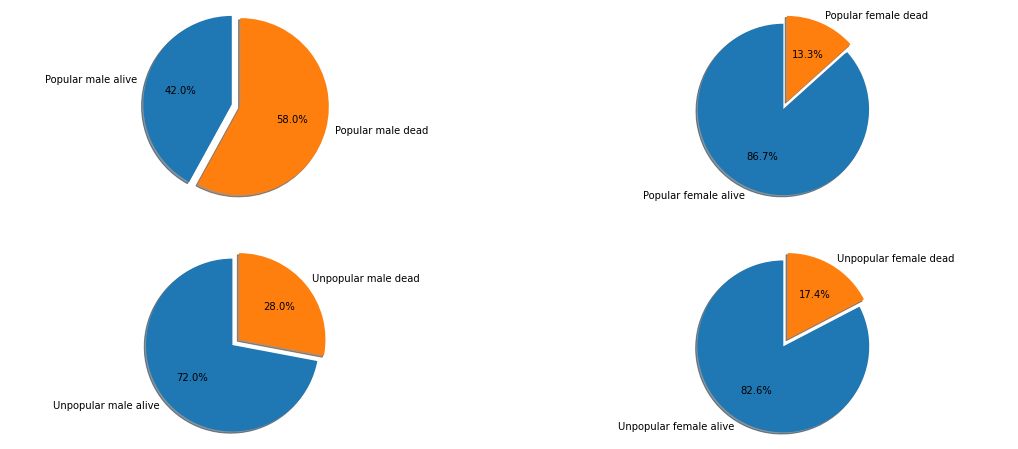

In [23]:
pm, c_pma, c_pmd = filter_data(data_got, True, True)
pf, c_pfa, c_pfd = filter_data(data_got, True, False)
npm, c_npma, c_npmd = filter_data(data_got, False, True)
npf, c_npfa, c_npfd = filter_data(data_got, False, False)


fig, ax = plt.subplots(2, 2, figsize=(18, 8))
explode = (0, 0.1)
plot_pie([c_pma, c_pmd], ["Popular male alive", "Popular male dead"], ax[0][0], explode)
plot_pie(
    [c_pfa, c_pfd], ["Popular female alive", "Popular female dead"], ax[0][1], explode
)
plot_pie(
    [c_npma, c_npmd], ["Unpopular male alive", "Unpopular male dead"], ax[1][0], explode
)
plot_pie(
    [c_npfa, c_npfd],
    ["Unpopular female alive", "Unpopular female dead"],
    ax[1][1],
    explode,
)
plt.show()

# 3.3 Famous People – Pantheon

## 3.3A

Use the person_2020_update.csv file to reproduce the plot shown below, as accurately as possible. You are free to use any geographic map library. I used the Python library Basemap. There is a section about it in the Data Science book we studied from.10 You can also read more about it here.11 Before you plot, make sure you only consider individuals who were born strictly after 1920, and have non-null values for the longitude and latitude coordinates of their birth and death locations.

In [24]:
import os
os.environ['PROJ_LIB'] = '/Users/jhwu/opt/anaconda3/envs/basemap-env/share/proj'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import chain
import dateutil

In [25]:
def get_map(data_map, start_year):
    df = data_map[
        (data_map.birthyear > start_year)
        & (data_map.bplace_lat.notnull())
        & (data_map.bplace_lon.notnull())
        & (data_map.dplace_lat.notnull())
        & (data_map.dplace_lon.notnull())
    ]
    fig = plt.figure(figsize=(18, 16), edgecolor="w")
    m = Basemap(
        projection="cyl",
        resolution="c",
        llcrnrlat=-50,
        urcrnrlat=70,
        llcrnrlon=-130,
        urcrnrlon=160,
    )
    m.drawparallels(np.arange(-90.0, 91.0, 15.0), color="white")
    m.drawmeridians(np.arange(-180.0, 181.0, 30.0), color="white")
    m.fillcontinents(color="white", lake_color="#9DCFE6")
    m.drawmapboundary(fill_color="#9DCFE6")
    m.plot(
        df.bplace_lon,
        df.bplace_lat,
        "ok",
        markersize=1,
        label="Birth Place",
        color="green",
    )
    m.plot(
        df.dplace_lon,
        df.dplace_lat,
        "ok",
        markersize=1,
        label="Death Place",
        color="red",
    )
    plt.legend(loc="lower left")
    plt.show()

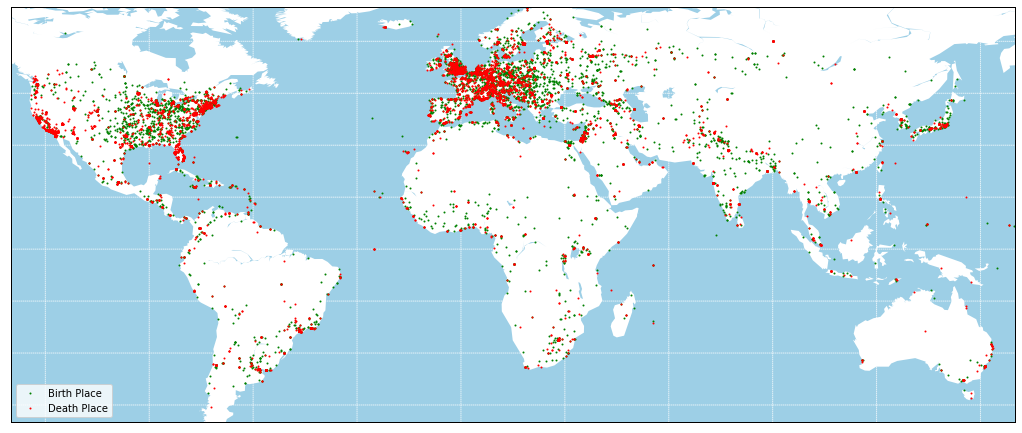

In [26]:
filepath = r"./person_2020_update.csv"
data_map = pd.read_csv(filepath, low_memory=False)
get_map(data_map, 1920)

## 3.3B

We want to know which countries have the most celebrities. 
It is not difficult to see that the more developed countries are, the more celebrities are likely to appear.

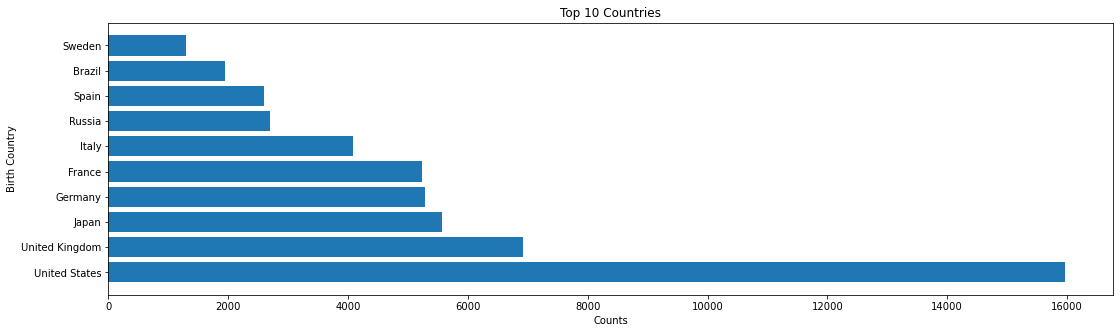

In [27]:
df = data_map.groupby(["bplace_country"]).size().reset_index(name="counts")
df = df.nlargest(10, "counts")
fig, ax = plt.subplots(figsize=(18, 5))
ax.barh(df["bplace_country"], df["counts"])
ax.set_title("Top 10 Countries")
ax.set_ylabel("Birth Country")
ax.set_xlabel("Counts")
plt.show()